<br><br/>
<center><span style="color:black; font-weight: bold; font-size:24pt">Определение перспективного тарифа для телеком компании</span></center>
<br><br/>

# 1. Введение

***Описание проекта***

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

***Описание тарифов***

*Тариф «Смарт»*

1. Ежемесячная плата: 550 рублей
1. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*

1. Ежемесячная плата: 1950 рублей
1. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
**Обратите внимание:** «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## 1.1. Imports

In [1]:
import pandas as pd
import numpy as np
from math import ceil
from scipy import stats as st
import matplotlib.pyplot as plt

## 1.2. Чтение данных

In [2]:
# локальная работа
# path = './datasets/'

# сервер Практикума
path = '/datasets/'

users = pd.read_csv(path + 'users.csv')
calls = pd.read_csv(path + 'calls.csv')
messages = pd.read_csv(path + 'messages.csv')
internet = pd.read_csv(path + 'internet.csv')
tariffs = pd.read_csv(path + 'tariffs.csv')

Сразу добавим параметр с именем для датасетов для дальнейшего удобства

In [3]:
all_df = [users,calls,messages,internet,tariffs]

In [4]:
users.name = 'users'
calls.name = 'calls'
messages.name = 'messages'
internet.name = 'internet'
tariffs.name = 'tariffs'

***
Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [5]:
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


***
Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [6]:
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


***
Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [7]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


***
Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [8]:
display(internet.head())
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


***
Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [9]:
display(tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Вывод по 1.2** :
- на первый взгляд данные хорошо подготовлены
- пропуски только в `churn_date` таблицы `users`, что вполне логично
- также необходимо преобразовать некоторые колонки к корректному типу данных
- первая колонка таблицы `internet` дублирует индексы

## 1.3. Проверки

### 1.3.1. Пропуски

In [10]:
# Ищем пропуски во всех имеющихся `DataFrame` и выводим на экран
for df in all_df:
    na = [[col, df[col].isna().sum()] for col in df.columns if df[col].isna().sum()!=0]
    if na:
        print(f'Пропуски \'{df.name}\':', sep='\n\t', *na)

Пропуски 'users':
	['churn_date', 462]


Одна колонка с пропусками, что логично, т.к. 462 абонента из 500 всё еще пользуются мобильной связью оператора

### 1.3.2. Типы данных

In [11]:
# Ищем колонки `date` во всех имеющихся `DataFrame`, выводим на экран и дополнительно сохраняем в словарь `date_col_dict`
date_col_dict = {}
for df in all_df:
    date_col = [col for col in df.columns if 'date' in col]
    if date_col:
        date_col_dict[df.name] = date_col
        print(f'Колонки даты \'{df.name}\':', *date_col)

Колонки даты 'users': churn_date reg_date
Колонки даты 'calls': call_date
Колонки даты 'messages': message_date
Колонки даты 'internet': session_date


Далее в п.2.2 будем приводить эти колонки к типу `DateTime`

### 1.3.3. Дубликаты

In [12]:
# Ищем дубликаты во всех имеющихся `DataFrame` и выводим на экран
for df in all_df:
    print(f'Дубликаты в \'{df.name}\':', df.duplicated().sum())

Дубликаты в 'users': 0
Дубликаты в 'calls': 0
Дубликаты в 'messages': 0
Дубликаты в 'internet': 0
Дубликаты в 'tariffs': 0


Очевидных дублей нет

### 1.3.4. Ошибки

Проверим имеющиеся числовые значения: `users['age']`, `calls['duration']`, `internet['mb_used']` на выбросы

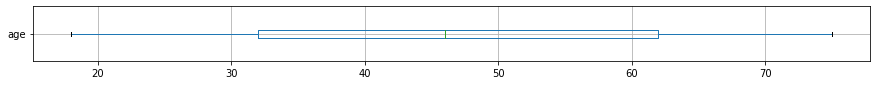

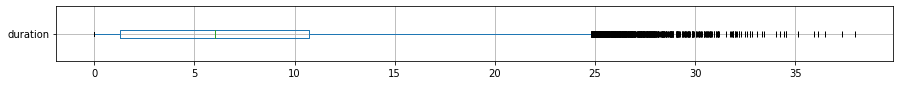

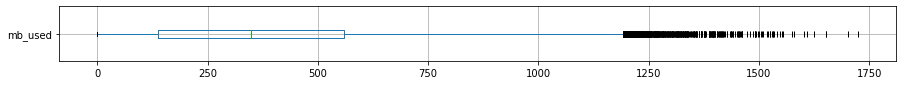

In [13]:
# Можно так
# print(users['age'].describe(),'\n') # возраст в годах
# print(calls['duration'].describe(),'\n') # длительность разговора в минутах
# print(internet['mb_used'].describe(),'\n') # объем трафика в МБ

# Но так нагляднее
users['age'].plot.box(figsize=(15,1), grid=True, vert=False)
plt.show()
calls['duration'].plot.box(figsize=(15,1), grid=True, vert=False, sym='|')
plt.show()
internet['mb_used'].plot.box(figsize=(15,1), grid=True, vert=False, sym='|')
plt.show()

Вроде бы всё неплохо, теперь посмотрим на распределения этих данных

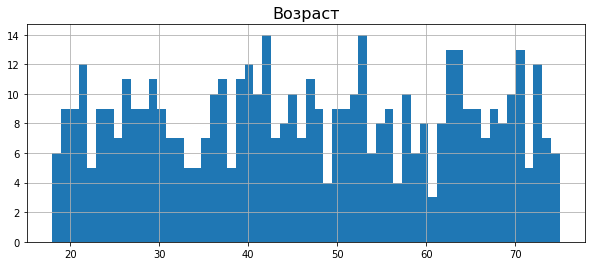

In [14]:
plt.figure(figsize=(10,4))
users['age'].hist(bins=len(users['age'].unique()))
plt.title('Возраст', fontsize=16)
plt.show()

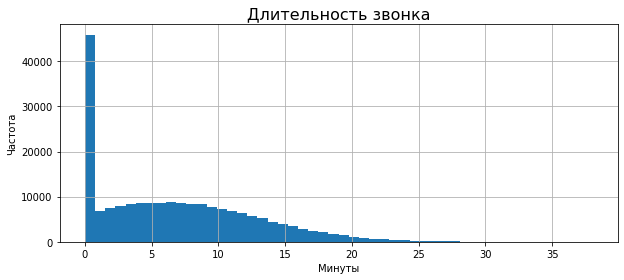

In [15]:
plt.figure(figsize=(10,4))
calls['duration'].hist(bins=50)
plt.title('Длительность звонка', fontsize=16)
plt.xlabel('Минуты')
plt.ylabel('Частота')
plt.show()

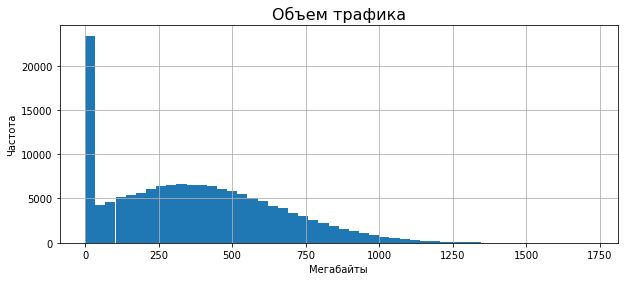

In [16]:
plt.figure(figsize=(10,4))
internet['mb_used'].hist(bins=50)
plt.title('Объем трафика', fontsize=16)
plt.xlabel('Мегабайты')
plt.ylabel('Частота')
plt.show()

**Вывод по 1.3:**
- с нулевыми пиками на гистограммах звонков и трафика необходимо что-то делать
- колонки с датами необходимо привести к типу `DateTime`
- выбросов нет
- явных дублей нет
- критичных пропусков нет

Критических ошибок в данных обнаружено не было.
        
Большое количество "пустых" звонков - очевидно, что это несостоявщиеся разговоры. Т.к. у оператора они никак не тарифицируются, то для дальнейших вычислений нам эти значения попросту не нужны.
        
Аналогичная ситуация с "пустыми" сессиями. Вероятно, многие пользователи постоянно используют режим пакетной передачи данных на своих смартфонах, но при этом никаких данных не передают.     

# 2. Предобработка

### 2.1. Пропуски
Оставим пропуски `churn_date` на местах

### 2.2. Типы данных

Приводим к типу `DateTime`

In [17]:
for df in all_df:
    if df.name in date_col_dict: # словарь date_col_dict был определен в п.1.3.2
        for col in date_col_dict[df.name]:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')

Проверяем

In [18]:
for df in all_df:
    for col in df.columns:
        print(f'Тип {df.name}[\'{col}\'] = {df[col].dtype.name}')
    print()

Тип users['user_id'] = int64
Тип users['age'] = int64
Тип users['churn_date'] = datetime64[ns]
Тип users['city'] = object
Тип users['first_name'] = object
Тип users['last_name'] = object
Тип users['reg_date'] = datetime64[ns]
Тип users['tariff'] = object

Тип calls['id'] = object
Тип calls['call_date'] = datetime64[ns]
Тип calls['duration'] = float64
Тип calls['user_id'] = int64

Тип messages['id'] = object
Тип messages['message_date'] = datetime64[ns]
Тип messages['user_id'] = int64

Тип internet['Unnamed: 0'] = int64
Тип internet['id'] = object
Тип internet['mb_used'] = float64
Тип internet['session_date'] = datetime64[ns]
Тип internet['user_id'] = int64

Тип tariffs['messages_included'] = int64
Тип tariffs['mb_per_month_included'] = int64
Тип tariffs['minutes_included'] = int64
Тип tariffs['rub_monthly_fee'] = int64
Тип tariffs['rub_per_gb'] = int64
Тип tariffs['rub_per_message'] = int64
Тип tariffs['rub_per_minute'] = int64
Тип tariffs['tariff_name'] = object



Альтернативное отображение:

In [19]:
dtypes = pd.DataFrame(columns=['table','column','dtype'])

for df in all_df:
    for col in df.columns:
        dtypes = dtypes.append({'table': df.name, 'column': col, 'dtype': df[col].dtype.name}, ignore_index=True)

dtypes.set_index(['table','column'])

dtype
table    column                               
users    user_id                         int64
         age                             int64
         churn_date             datetime64[ns]
         city                           object
         first_name                     object
         last_name                      object
         reg_date               datetime64[ns]
         tariff                         object
calls    id                             object
         call_date              datetime64[ns]
         duration                      float64
         user_id                         int64
messages id                             object
         message_date           datetime64[ns]
         user_id                         int64
internet Unnamed: 0                      int64
         id                             object
         mb_used                       float64
         session_date           datetime64[ns]
         user_id                         int64
tariffs  messages_included               int64
         mb_per_month_included           int64
         minutes_included                int64
         rub_monthly_fee                 int64
         rub_per_gb                      int64
         rub_per_message                 int64
         rub_per_minute                  int64
         tariff_name                    object

### 2.3. Замены ошибок

#### 2.3.1

Установим корректный индекс в `internet`

In [20]:
internet.set_index('Unnamed: 0', inplace=True)

#### 2.3.2. Длительность звонка

Скорее всего поля `0` минут - это неотвеченные вызовы. Посмотрим, какова ситуация без них

Кол-во пропущенных вызовов: 39613

С пропущенными вызовами:
 count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Без пропущенных вызовов:
 count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64


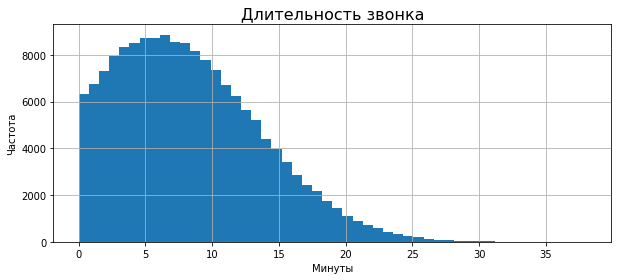

In [21]:
print('Кол-во пропущенных вызовов:',(calls['duration'] == 0).sum())
print()
print('С пропущенными вызовами:\n',calls['duration'].describe())
print()
print('Без пропущенных вызовов:\n',calls[calls['duration'] != 0]['duration'].describe())

plt.figure(figsize=(10,4))
calls[(calls['duration'] != 0)]['duration'].hist(bins=50)
plt.title('Длительность звонка', fontsize=16)
plt.xlabel('Минуты')
plt.ylabel('Частота')
plt.show()

#### 2.3.3 Объем трафика
Оценим теперь маленькие значения трафика

Кол-во сессий без трафика: 19598

С нулевыми сессиями:
 count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Без нулевых сессий:
 count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64


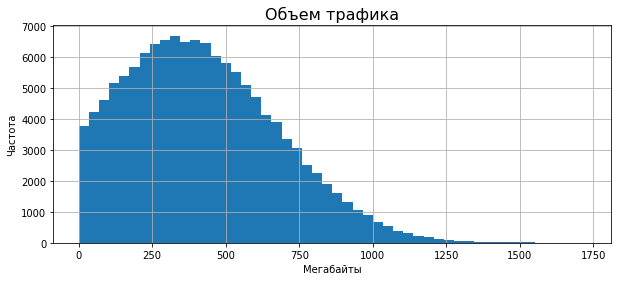

In [22]:
print('Кол-во сессий без трафика:',(internet[internet['mb_used'] == 0]['mb_used'].count()))
print()
print('С нулевыми сессиями:\n',internet['mb_used'].describe())
print()
print('Без нулевых сессий:\n',internet[internet['mb_used'] != 0]['mb_used'].describe())

plt.figure(figsize=(10,4))
internet[internet['mb_used'] != 0]['mb_used'].hist(bins=50)
plt.title('Объем трафика', fontsize=16)
plt.xlabel('Мегабайты')
plt.ylabel('Частота')
plt.show()

**Вывод 2.3:** Очевидно, что необходимо будет при рассчетах учитывать влияние 39613 пропущенных звонков и 19598 сессий без трафика. Но т.к. в описании к тарифам не указано, оплачиваются ли такие звонки и интернет-сессии, то учитывать последние не обязательно

# 3. Рассчеты
Добавим колонку с округленной вверх длительностью разговоров и объемом трафика:

In [23]:
calls['duration_ceil'] = calls['duration'].apply(ceil)
internet['mb_used_ceil'] = internet['mb_used'].apply(ceil)

Для каждого пользователя произведем следующие рассчеты:

## 3.1. Количество сделанных звонков и израсходованных минут разговора по месяцам

Создадим сводные таблицы для количества пропущенных и нормальных звонков и суммарной длительности разговоров по месяцам для каждого пользователя

In [24]:
# Количество и длительность нормальных звонков по месяцам
by_month = calls[calls['duration_ceil'] != 0].pivot_table(index=['user_id',calls['call_date'].dt.month],
                                                          aggfunc={'duration_ceil':['count', 'sum']},
                                                          dropna=False,
                                                          fill_value=0
                                                         )
# переименуем oсь индексов `call_date` на `month`
by_month.rename_axis(['user_id','month'], inplace=True)
# Уберем мультииндекс колонок
by_month.columns = ['calls_count','calls_duration']

In [25]:
# проверка
by_month

calls_count  calls_duration
user_id month                             
1000    1                0               0
        2                0               0
        3                0               0
        4                0               0
        5               17             159
...                    ...             ...
1499    8                0               0
        9                8              70
        10              44             449
        11              62             612
        12              56             492

[5904 rows x 2 columns]

Можно не хранить все данные, убрав параметр dropna=False из метода .pivot_table()
        
Объясню, почему сделал полную таблицу: мне хотелось видеть полную статистику по всем 500 абонентам за каждый из 12 месяцев (6000 строк). Так можно понять, что некоторые абоненты совсем не проявляют активности. в пункте 3.2 видно, что записей станет 5976, что соответствует 498 абонентам, т.е. 2 человека целый год не пользовались связью

## 3.2. Количество отправленных сообщений по месяцам
Аналогичные рассчеты для количества сообщений

In [26]:
# применяем склеивание данных из обоих таблиц, чтобы не упустить непересекающиеся индексы
by_month = pd.concat([by_month, messages.pivot_table(index=['user_id', messages['message_date'].dt.month],
                                                     aggfunc={'id':'count'},
                                                     dropna=False,
                                                     fill_value=0)],
                     axis = 1)
by_month.columns = ['calls_count', 'calls_duration', 'message_count']

Заменим появившиеся после сколеивания `NaN` на `0`

In [27]:
by_month.fillna(0, inplace=True)
by_month.rename_axis(['user_id','month'], inplace=True)
by_month

calls_count  calls_duration  message_count
user_id month                                            
1000    1              0.0             0.0            0.0
        2              0.0             0.0            0.0
        3              0.0             0.0            0.0
        4              0.0             0.0            0.0
        5             17.0           159.0           22.0
...                    ...             ...            ...
1499    8              0.0             0.0            0.0
        9              8.0            70.0           11.0
        10            44.0           449.0           48.0
        11            62.0           612.0           59.0
        12            56.0           492.0           66.0

[5976 rows x 3 columns]

Добавилось 72 строки, видимо к первой таблице добавились дополнительные индексы (некоторые клиенты в какие-то месяцы пользовались только СМС)

## 3.3. Объем израсходованного интернет-трафика по месяцам


In [28]:
# применяем склеивание данных из обоих таблиц, чтобы не упустить непересекающиеся индексы
by_month = pd.concat([by_month, internet.pivot_table(index=['user_id', internet['session_date'].dt.month],
                                          aggfunc={'mb_used_ceil':'sum'},
                                          dropna=False,
                                          fill_value=0)], axis = 1)
by_month.columns = ['calls_count', 'calls_duration', 'message_count', 'traffic_mb']

Заменим появившиеся после сколеивания `NaN` на `0`

In [29]:
by_month.fillna(0, inplace=True)

In [30]:
# почему-то слетает название оси с индексами
# поэтому устанавливаем снова и смотрим итог
by_month.rename_axis(['user_id','month'], inplace=True)
by_month.head()

calls_count  calls_duration  message_count  traffic_mb
user_id month                                                        
1000    1              0.0             0.0            0.0         0.0
        2              0.0             0.0            0.0         0.0
        3              0.0             0.0            0.0         0.0
        4              0.0             0.0            0.0         0.0
        5             17.0           159.0           22.0      2256.0

## 3.4. Помесячная выручка с каждого пользователя


Сначала в `by_month` добавим по `user_id` колонки `reg_date`,`churn_date`,`city`,`tariff` из таблицы `users`

In [31]:
by_month = (by_month
 .join(users.set_index('user_id')[['reg_date','churn_date','city','tariff']])
#  .join(tariffs.set_index('tariff_name'), on='tariff')
)

In [32]:
by_month.reset_index(inplace=True)
# пример
by_month.head()

,user_id,month,calls_count,calls_duration,message_count,traffic_mb,reg_date,churn_date,city,tariff
0,1000,1,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra
1,1000,2,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra
2,1000,3,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra
3,1000,4,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra
4,1000,5,17.0,159.0,22.0,2256.0,2018-05-25,NaT,Краснодар,ultra


Определяем функцию для подсчета выручки из нашей таблицы

Необходимо:
1. вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
2. остаток умножить на значение из тарифного плана
3. прибавить абонентскую плату, соответствующую тарифному плану

In [33]:
tariffs.set_index('tariff_name', inplace=True)

In [34]:
def profit(row):
    # до/сверх тарифа
    minuts = row['calls_duration'] - tariffs.loc[row['tariff'],'minutes_included']
    message = row['message_count'] - tariffs.loc[row['tariff'],'messages_included']
    traffic = row['traffic_mb'] - tariffs.loc[row['tariff'],'mb_per_month_included']
    # переплаты
    over_minuts = 0
    over_message = 0
    over_traffic = 0
    if minuts > 0:
        over_minuts = minuts*tariffs.loc[row['tariff'],'rub_per_minute']
    if message > 0:
        over_message = message*tariffs.loc[row['tariff'],'rub_per_message']
    if traffic > 0:
        over_traffic = ceil(traffic/1024)*tariffs.loc[row['tariff'],'rub_per_gb']
    # возвращаем суммарные затраты абонента за 1 месяц
    return tariffs.loc[row['tariff'],'rub_monthly_fee'] + over_minuts + over_message + over_traffic

Оставим только месяца, в которые абонент пользовался оператором и посчитаем выручку

In [35]:
by_month['profit'] = (by_month
 .query('reg_date.dt.month <= month')
 .query('churn_date=="NaN" | month <= churn_date.dt.month')
 .apply(profit, axis=1)
)
by_month['profit'] = by_month['profit'].fillna(0).astype('int')

In [36]:
by_month

,user_id,month,calls_count,calls_duration,message_count,traffic_mb,reg_date,churn_date,city,tariff,profit
0,1000,1,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra,0
1,1000,2,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra,0
2,1000,3,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra,0
3,1000,4,0.0,0.0,0.0,0.0,2018-05-25,NaT,Краснодар,ultra,0
4,1000,5,17.0,159.0,22.0,2256.0,2018-05-25,NaT,Краснодар,ultra,1950
...,...,...,...,...,...,...,...,...,...,...,...
5971,1499,8,0.0,0.0,0.0,0.0,2018-09-27,NaT,Пермь,smart,0
5972,1499,9,8.0,70.0,11.0,1848.0,2018-09-27,NaT,Пермь,smart,550
5973,1499,10,44.0,449.0,48.0,17809.0,2018-09-27,NaT,Пермь,smart,1150
5974,1499,11,62.0,612.0,59.0,17984.0,2018-09-27,NaT,Пермь,smart,1513


# 4. Анализ данных
Неоходимо:
- описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- посчитать среднее количество, дисперсию и стандартное отклонение
- построить гистограммы
- описать распределения

Посчитаем статистики:

In [37]:
print('{:_^46}'.format('Количество звонков'))
display(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['calls_count']
 .describe()
 .style.format("{:.1f}"))

print('\n{:_^50}'.format('Длительность звонков'))
display(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['calls_duration']
 .describe()
 .style.format("{:.1f}"))

print('\n{:_^46}'.format('Сообщения'))
display(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['message_count']
 .describe()
 .style.format("{:.1f}"))

print('\n{:_^60}'.format('Траффик'))
display(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['traffic_mb']
 .describe()
 .style.format("{:.1f}"))

______________Количество звонков______________


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,46.9,21.0,0.0,32.0,47.0,61.0,162.0
ultra,985.0,59.2,35.6,0.0,33.0,58.0,84.0,190.0



_______________Длительность звонков_______________


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,417.9,190.3,0.0,282.0,422.0,545.0,1435.0
ultra,985.0,526.6,317.6,0.0,284.0,518.0,752.0,1673.0



__________________Сообщения___________________


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,33.4,28.2,0.0,10.0,28.0,51.0,143.0
ultra,985.0,49.4,47.8,0.0,6.0,38.0,79.0,224.0



__________________________Траффик___________________________


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,16229.2,5877.6,0.0,12658.0,16531.0,20068.0,38610.0
ultra,985.0,19486.9,10096.3,0.0,11785.0,19324.0,26863.0,49789.0


Сделаю немного короче и вывод только необходимых статистик:

In [38]:
(by_month[by_month['profit']!=0]
 .pivot_table(index=['tariff'], aggfunc={'calls_count':['mean','var','std'],
                                         'calls_duration':['mean','var','std'],
                                         'message_count':['mean','var','std'],
                                         'traffic_mb':['mean','var','std'],
                                        })
 .style.format("{:.1f}")
)

Заметно, что по тарифу `ultra` пользователи немного активнее по всем показателям.

Построим теперь гистограммы

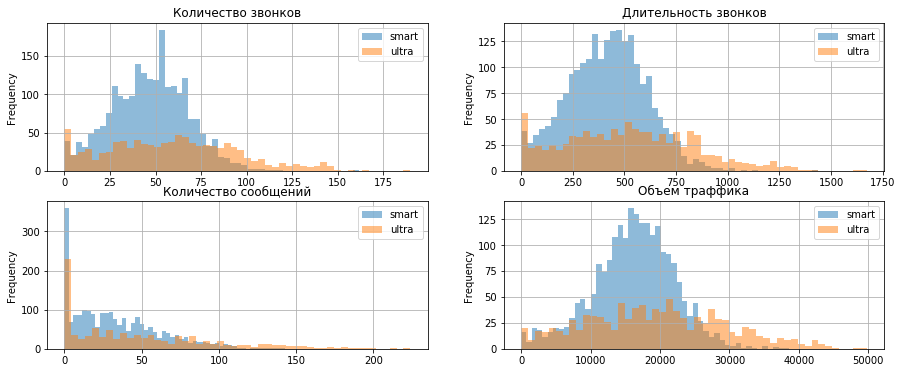

In [39]:
fig, axes  = plt.subplots(nrows = 2, ncols = 2, figsize=(15,6))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['calls_count']
 .plot(kind='hist', title='Количество звонков', bins=50, alpha=0.5, grid=True, ax=axes[0, 0], legend=True))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['calls_duration']
 .plot(kind='hist', title='Длительность звонков', bins=50, alpha=0.5, grid=True, ax=axes[0, 1], legend=True))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['message_count']
 .plot(kind='hist', title='Количество сообщений', bins=50, alpha=0.5, grid=True, ax=axes[1, 0], legend=True))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['traffic_mb']
 .plot(kind='hist', title='Объем траффика', bins=50, alpha=0.5, grid=True, ax=axes[1, 1], legend=True))
plt.show()

Из-за того, что количество пользователей `smart` больше, на всех гистограммах `smart` расположен заметно выше, поэтому для наглядности используем плотности распределений:

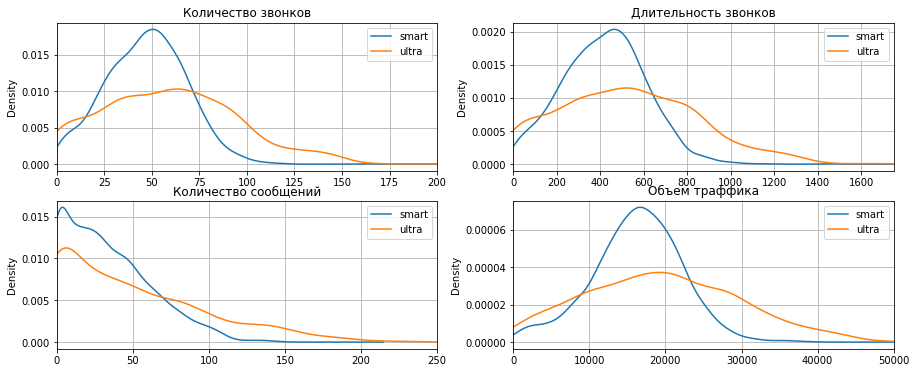

In [40]:
fig, axes  = plt.subplots(nrows = 2, ncols = 2, figsize=(15,6))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['calls_count']
 .plot(kind='kde', title='Количество звонков', xlim=(0,200), grid=True, ax=axes[0, 0], legend=True))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['calls_duration']
 .plot(kind='kde', title='Длительность звонков', xlim=(0,1750), grid=True, ax=axes[0, 1], legend=True))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['message_count']
 .plot(kind='kde', title='Количество сообщений', xlim=(0,250), grid=True, ax=axes[1, 0], legend=True))

(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['traffic_mb']
 .plot(kind='kde', title='Объем траффика', xlim=(0,50000), grid=True, ax=axes[1, 1], legend=True))
plt.show()

**Выводы:**
- пользователи тарифа `ultra` расположены в более широком диапазоне графиков, что вероятно связано с бОльшими лимитами по этому тарифу
- все распределения имеют достаточно длинный "хвост"
- пики графиков 'Длительность звонков' и 'Объем траффика' тарифа `smart` практически совпадают с тарифными лимитами (500 мин и 15 ГБ)
- сообщениями в 21 веке пользуются редко

Вывод в цикле:

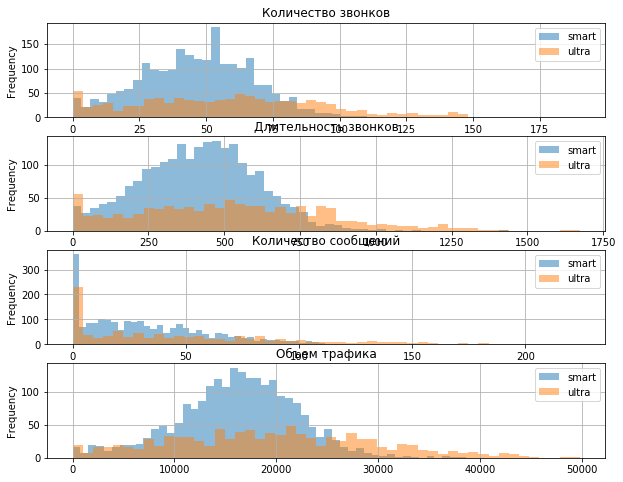

In [41]:
col = {'calls_count':'Количество звонков',
       'calls_duration':'Длительность звонков',
       'message_count':'Количество сообщений',
       'traffic_mb':'Объем трафика'}
fig, axes  = plt.subplots(nrows = 4, ncols = 1, figsize=(10,8))
n=0
for i,j in col.items():
    (by_month[by_month['profit']!=0]
     .groupby(by=['tariff'])[i]
     .plot(kind='hist', title=j, bins=50, alpha=0.5, grid=True, ax=axes[n], legend=True))
    n+=1

# 5. Проверка гипотез

## 5.1. Средняя выручка пользователей тарифов `«Ультра»` и `«Смарт»` различается
Сформулируем нулевую гипотезу: выручка пользователей тарифов `«Ультра»` и `«Смарт»` совпадает

Альтернативная гипотеза: выручки различаются

Уровень значимости зададим в 5%. Используем метод `ttest_ind` для сравнения двух независимых выборок с параметром `equal_var=False`, т.к. дисперсии у наших выборок будут различаться

Проверка равенства дисперсий   

In [42]:
(by_month[by_month['profit']!=0]
 .pivot_table(index=['tariff'], aggfunc={'profit':'var'})
 .style.format("{:.1f}")
)

,profit
tariff,
smart,673931.3
ultra,143491.2


In [43]:
alpha = .05
results = st.ttest_ind(
    by_month[(by_month['profit']!=0) & (by_month['tariff']=='smart')]['profit'], 
    by_month[(by_month['profit']!=0) & (by_month['tariff']=='ultra')]['profit'],
    equal_var=False
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


Можно сделать вывод, что данные противоречат нашей гипотезе о равенстве выручки `«Ультра»` и `«Смарт»`, следовательно, скорее всего **выручки различаются**.

Для наглядности сравним методом `describe`:

In [44]:
(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['profit']
 .describe()
 .style.format("{:.1f}"))

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,1294.6,820.9,550.0,550.0,1038.0,1750.0,6770.0
ultra,985.0,2071.1,378.8,1950.0,1950.0,1950.0,1950.0,4800.0


График для наглядности

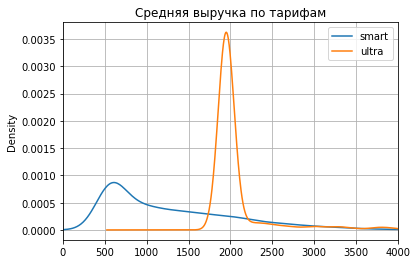

In [45]:
(by_month[by_month['profit']!=0]
 .groupby(by=['tariff'])['profit']
 .plot(kind='kde', title='Средняя выручка по тарифам',xlim=(0,4000), grid=True, legend=True))
plt.show()

## 5.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Сначала добавим в нашу таблицу колонку `district`, в которой будут два значения `Москва` или `Регион`

In [46]:
by_month['district'] = by_month['city'].where(by_month['city'] == 'Москва', 'Регион')

Сформулируем нулевую гипотезу: выручка пользователей из Москвы **равна** выручке пользователей из других регионов

Альтернативная гипотеза: выручки различаются

Уровень значимости зададим в 5%. Используем метод `ttest_ind` для сравнения двух независимых выборок с параметром `equal_var=True`, т.к. нет оснований полагать, что дисперсии разные

In [47]:
alpha = .05
results = st.ttest_ind(
    by_month[(by_month['profit']!=0) & (by_month['district']=='Москва')]['profit'], 
    by_month[(by_month['profit']!=0) & (by_month['district']=='Регион')]['profit'],
    equal_var=True
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Cредние значения различаются, но с вероятностью в 53% такое или большее различие можно получить случайно. Делаем вывод, что данные не противоречат нашей гипотезе, следовательно, скорее всего **выручки равны**.

Для наглядности сравним методом `describe`:

In [48]:
(by_month[by_month['profit']!=0]
 .groupby(by=['district','tariff'])['profit']
 .describe()
 .style.format("{:.1f}"))

График для наглядности:

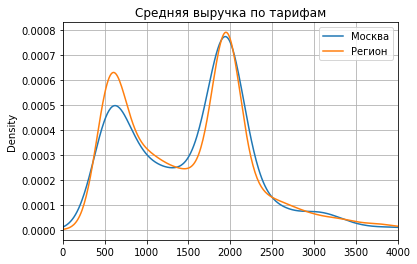

In [49]:
(by_month[by_month['profit']!=0]
 .groupby(by=['district'])['profit']
 .plot(kind='kde', title='Средняя выручка по тарифам',xlim=(0,4000), grid=True, legend=True))
plt.show()

Визуально заметно, что в регионах первый пик выше, соответственно там больше абонентов с тарифом `smart`.

Проверим другую гипотезу: выручка пользователей тарифа `smart` из Москвы **равна** выручке пользователей из других регионов

Альтернативная гипотеза: выручки различаются

Уровень значимости зададим в 5%. Используем метод `ttest_ind` для сравнения двух независимых выборок с параметром `equal_var=True`, т.к. нет оснований полагать, что дисперсии разные

In [50]:
alpha = .05
results = st.ttest_ind(
    by_month[(by_month['profit']!=0) & (by_month['district']=='Москва') & (by_month['tariff']=='smart')]['profit'], 
    by_month[(by_month['profit']!=0) & (by_month['district']=='Регион') & (by_month['tariff']=='smart')]['profit'],
    equal_var=True
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.19196326570657848
Не получилось отвергнуть нулевую гипотезу


Немного другое p-значение, но не достаточное для альтернативного вывода.

# 6. Выводы
- предоставленные данные не нуждаются в тщательной предобработке. Были исправлены некоторые типы данных, заменен индекс в таблице `internet` и обнаружены нулевые значения в таблицах `calls` и `internet`
- собрана таблица с ежемесечным суммарным количеством минут, сообщений и объемом трафика по каждому пользователю
- для каждого пользователя в каждом месяце рассчитана выручка
- проанализированы потребности абонентов разных тарифов по `длительности звонков`, `количеству сообщений` и `объему трафика`:
    - плотности распределений по этим параметрам пользователей тарифа `ultra` имеют бОльшую дисперсию
    - средние значения также больше у пользователей тарифа `ultra`
- гипотеза о равенстве выручки пользователей разных тарифов была *отвергнута*, что вполне логично
- гипотезу о равенстве выручки пользователей из Москвы и других регионов *не получилось отвергнуть*

Upd:
        
- количество ежемесячно активных пользователей "smart" более чем в два раза превышает количество пользователей "ultra". Изходя из этого суммарная прибыль компании от тарифа "smart" будет больше
        
- в регионах тариф "smart" немного популярнее и выгоднее (это предположение, т.к. для эта гипотеза не проверялась)
        
Если определить, например, метрику выгоды для отдельного абонента равную отношению выручки к количеству звонков и трафика, то, скорее всего, выгоднее для компании будет тариф "ultra". Т.к. пользователь "ultra" за 1 Гб/Смс/минуту в среднем будет платить больше, чем пользователь "smart"
        
Но рассчет такой метрики лежит за пределом данного проекта, так что в следующий раз